## Done
* Make a basic CTRNN cell work

## ToDo
* Make work with 3 dimensional input

Good inspiration if you get stuck: [A noob’s guide to implementing RNN-LSTM using Tensorflow](http://monik.in/a-noobs-guide-to-implementing-rnn-lstm-using-tensorflow/)

Different cell types: [documentation](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn)

In [1]:
from __future__ import absolute_import, division, print_function

"""
Imports
"""
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
RANDOM_SEED = 1234

In [3]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(num_epochs, batch_size, num_steps):
    for i in range(num_epochs):
        yield gen_batch(gen_data(), batch_size, num_steps)

def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()
    

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out



In [9]:
# Global config variables
# batch_size = 200

num_steps = 10 # number of truncated backprop steps ('n' in the discussion above)
batch_size= 200
num_epochs=5
learning_rate = 0.01

num_units = 16
input_dim = 2
num_input_class = input_dim
output_dim = 2

In [10]:
from CTRNN import CTRNNModel

In [11]:
def train_network(model, num_epochs, batch_size=32, num_steps=200, verbose=True, save=False):
    tf.set_random_seed(RANDOM_SEED)
    training_losses = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        print('\tBegin training loop')
        for idx, epoch in enumerate(gen_epochs(num_epochs, batch_size, num_steps)):
            print('epoch', idx)
            training_loss = 0
            steps = 0
            state_tuple = model.zero_state_tuple(batch_size=batch_size)
#             print('state_tuple', type(state_tuple[0]), state_tuple[0].get_shape(), 
#                   state_tuple[1][0].get_shape(), state_tuple[1][0].get_shape())
            for X, Y in epoch:
#                 X = onehot(X, input_dim)
#                 print('X!', X.shape)
                steps += 1
                feed_dict = {model.x:X, model.y:Y, model.init_tuple:state_tuple}
                training_loss_, _, state_tuple = sess.run([
                        model.total_loss, 
                        model.train_op,
                        model.state_tuple
                    ], 
                        feed_dict=feed_dict)
                training_loss += training_loss_

                if steps % 100 == 0 and steps > 0:
                    if verbose:
                        print('Average loss at step', steps,
                             'for last 100 steps: ', training_loss/100.)
                    training_losses.append(training_loss/100.)
                    training_loss = 0                    
#                     break
#                 break
    return training_losses
        

In [12]:
# import CTRNN

tf.reset_default_graph()

y = tf.placeholder(tf.int32, shape=[None, num_steps], name='outputPlaceholder')
# x = tf.placeholder(tf.float32, shape=[None, num_steps, input_dim], name='inputPlaceholder')
x = tf.placeholder(tf.int32, shape=[None, num_steps], name='inputPlaceholder')
init_c1 = tf.placeholder(tf.float32, shape=[None, num_units], name='initC')
init_c2 = tf.placeholder(tf.float32, shape=[None, num_units], name='initC')
init_u = tf.placeholder(tf.float32, shape=[None, num_units], name='initU')
init_tuple = (init_c1, (init_c2, init_u))

print('Creating the model')
model = CTRNNModel(x=x, y=y, init_tuple=init_tuple, input_dim=input_dim, num_units=num_units, output_dim=output_dim, learning_rate=learning_rate)
print('\nTraining:')
loss = train_network(model, num_epochs=num_epochs, batch_size=batch_size, num_steps=num_steps)


print('Terminated!!')

Creating the model
x (?, 10, 2)
init_tuple <class 'tuple'>
init_tuple[0] (?, 16)
init_tuple[1][0] (?, 16)
init_tuple[1][1] (?, 16)

Training:
	Begin training loop
epoch 0
Average loss at step 100 for last 100 steps:  0.630801059604
Average loss at step 200 for last 100 steps:  0.592595253587
Average loss at step 300 for last 100 steps:  0.577055592537
Average loss at step 400 for last 100 steps:  0.536003700793
Average loss at step 500 for last 100 steps:  0.504294130802
epoch 1
Average loss at step 100 for last 100 steps:  0.486972828507
Average loss at step 200 for last 100 steps:  0.479574787021
Average loss at step 300 for last 100 steps:  0.478268867433
Average loss at step 400 for last 100 steps:  0.476775471866
Average loss at step 500 for last 100 steps:  0.475332196951
epoch 2
Average loss at step 100 for last 100 steps:  0.476080340445
Average loss at step 200 for last 100 steps:  0.472474900186
Average loss at step 300 for last 100 steps:  0.473222897351
Average loss at step

No learning:	 0.66
1 dep learning:	 0.52
2 dep learning:	 0.45


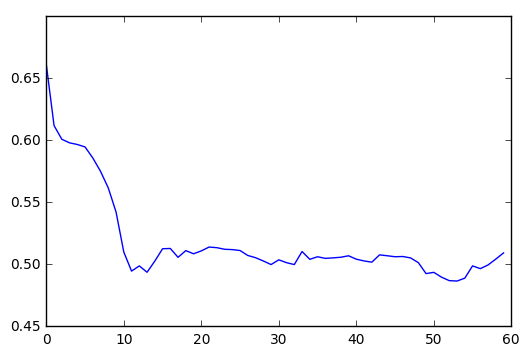

In [8]:
print('No learning:\t', 0.66)
print('1 dep learning:\t', 0.52)
print('2 dep learning:\t', 0.45)
plt.plot(loss)